In [2]:
!pip install fairlearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 41.2 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.3
    Uninstalling scipy-1.16.3:
      Successfully uninstalled scipy-1.16.3


In [3]:
import pandas as pd
import numpy as np

In [4]:
# UCI Adult dataset URL (no headers)
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"

# Define column names manually
columns = [
    "age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
    "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss",
    "hours-per-week", "native-country", "income"
]

# Load dataset
df = pd.read_csv(url, header=None, names=columns, na_values=" ?", skipinitialspace=True)
df.head()


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [5]:
# Check for missing values
print(df.isnull().sum())

# Drop rows with missing values
df.dropna(inplace=True)


age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64


In [6]:
from sklearn.preprocessing import LabelEncoder

# Encode target variable
df['income'] = LabelEncoder().fit_transform(df['income'])  # 0 = <=50K, 1 = >50K

# Encode sensitive attribute (sex)
df['sex'] = LabelEncoder().fit_transform(df['sex'])  # 0 = Female, 1 = Male

# Encode other categorical columns
categorical_cols = df.select_dtypes(include='object').columns
df = pd.get_dummies(df, columns=categorical_cols)


In [7]:
from sklearn.model_selection import train_test_split

X = df.drop('income', axis=1)
y = df['income']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [9]:
from fairlearn.metrics import MetricFrame
from sklearn.metrics import accuracy_score  # ✅ Correct source for accuracy_score

# Create fairness metric frame
mf = MetricFrame(metrics=accuracy_score,
                 y_true=y_test,
                 y_pred=y_pred,
                 sensitive_features=X_test['sex'])

# Print results
print("Overall Accuracy:", mf.overall)
print("Accuracy by Gender:", mf.by_group)


Overall Accuracy: 0.8450790726239829
Accuracy by Gender: sex
0    0.920508
1    0.808525
Name: accuracy_score, dtype: float64


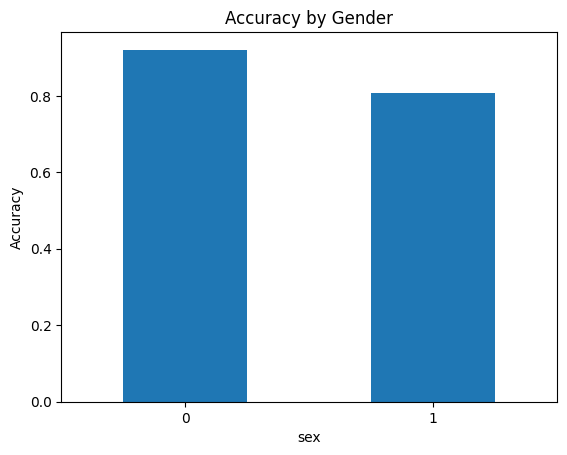

In [10]:
import matplotlib.pyplot as plt

mf.by_group.plot(kind='bar')
plt.title("Accuracy by Gender")
plt.ylabel("Accuracy")
plt.xticks(rotation=0)
plt.show()

In [12]:
from fairlearn.reductions import ExponentiatedGradient, DemographicParity
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Fairness constraint
constraint = DemographicParity()

# Create a pipeline with scaling + logistic regression
base_model = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(
        max_iter=5000,
        solver="lbfgs",
        n_jobs=-1
    ))
])

# Fair model
fair_model = ExponentiatedGradient(
    estimator=base_model,
    constraints=constraint,
    sample_weight_name="lr__sample_weight" # Specify how to pass sample weights to the pipeline
)

# Fit
fair_model.fit(
    X_train,
    y_train,
    sensitive_features=X_train["sex"]
)

# Predict
y_fair_pred = fair_model.predict(X_test)
